In [1]:
from keras_preprocessing.sequence import pad_sequences
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
import numpy as np
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import gensim.downloader as api
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
sys.path.append('../')
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.append(os.path.abspath(os.pardir))

from preprocessing import Preprocessor

ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, 'data', 'carer_emotion_dataset')
print(DATA_DIR)

label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}
glove_gensim  = api.load('glove-wiki-gigaword-100') #100 dimension

2021-12-16 17:45:43.090459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 17:45:43.090506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/daphne/PycharmProjects/sentiment_task/data/carer_emotion_dataset


## Load dataset

In [2]:
training_data = pd.read_csv(os.path.join(DATA_DIR, 'training.csv'), encoding='utf8')
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), encoding='utf8')
validation_data = pd.read_csv(os.path.join(DATA_DIR, 'validation.csv'), encoding='utf8')

dataset = pd.concat([training_data, test_data, validation_data], ignore_index=True)
dataset = dataset.sample(frac=1)
print(dataset.head())
print(dataset.shape)
print(dataset.columns)

                                                    text  label
1920   i continue to add more so please feel free to ...      1
4335      i just feel too stubborn to give up on a dream      3
19179  im feeling the need to stop and make some deli...      1
4625   im just not fully feeling it on an emotional l...      0
19944  i almost always feel the inside of my tire but...      3
(20000, 2)
Index(['text', 'label'], dtype='object')


In [3]:
corpus = []
for i, row in dataset.iterrows():
    preprocessor = Preprocessor(row['text'])
    words_list = preprocessor.get_preprocessed_list_words()
    text = ' '.join(words_list)
    corpus.append(text)

y = np.array(dataset['label'].tolist())
X = np.array(corpus, dtype=str)
# X = np.reshape(X, (len(corpus), 1)).tolist()
y = np.reshape(y, (len(dataset), 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [4]:
y_train_modified = to_categorical(y_train)
y_test_modified = to_categorical(y_test)
print(y_train.shape)
print(y_train_modified)

(15000, 1)
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [5]:
# url_regex = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
# special_chars = r"[^a-zA-Z0-9\s]+"
# html_tags = r'<.*?>'
num_words=1000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])
print(X_train_tok[2])

maxlen = 300
X_train = pad_sequences(X_train_tok, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test_tok, padding='post', maxlen=maxlen)

print(X_train[0, :])

would guilty conscience would feel like heartless bitch
[18, 243, 18, 1, 2, 870]
[  1 430  11 186   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   

In [6]:
vector_size = 100
gensim_weight_matrix = np.zeros((num_words, vector_size))
print(gensim_weight_matrix.shape)

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero
        try:
            gensim_weight_matrix[index] = glove_gensim.key_to_index[word]
        except:
            gensim_weight_matrix[index] = np.zeros(vector_size)

(1000, 100)


In [7]:
def create_model(num_words, input_length, gensim_weight_matrix):
    embedding_dim = 100
    input_dim = num_words
    output_dim = embedding_dim
    # input_length = X_train.shape[1]

    model = Sequential()
    model.add(layers.Embedding(input_dim=input_dim,
                               output_dim=output_dim,
                               input_length=input_length,
                               weights = [gensim_weight_matrix],
                               trainable = False))
    model.add(layers.Dropout(0.2))
    model.add(layers.Bidirectional(layers.LSTM(100, return_sequences=True)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Bidirectional(layers.LSTM(200,return_sequences=True)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Bidirectional(layers.LSTM(100,return_sequences=False)))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [8]:
model = create_model(num_words, X_train.shape[1], gensim_weight_matrix)
ts = TensorBoard(log_dir="./tensorboard_logs_lstm", histogram_freq=5)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(os.path.join(ROOT_DIR, 'models/best_model_lstm.h5'), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train_modified,
                    epochs=25,
                    verbose=True,
                    # validation_data=(X_test, y_test_modified),
                    batch_size=512,
                    validation_split=0.3,
                    callbacks=[es, ts, mc]
                    )

2021-12-16 17:46:39.437716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-16 17:46:39.437744: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-16 17:46:39.437768: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (daphne-Inspiron-5567): /proc/driver/nvidia/version does not exist
2021-12-16 17:46:39.438098: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          100000    
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 200)         160800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 300, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 400)         641600    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 300, 400)          0

In [ ]:
best_model = tf.keras.models.load_model(os.path.join(ROOT_DIR, 'models/best_model_lstm.h5'))
loss, accuracy = best_model.evaluate(X_train, y_train_modified, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = best_model.evaluate(X_test, y_test_modified, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

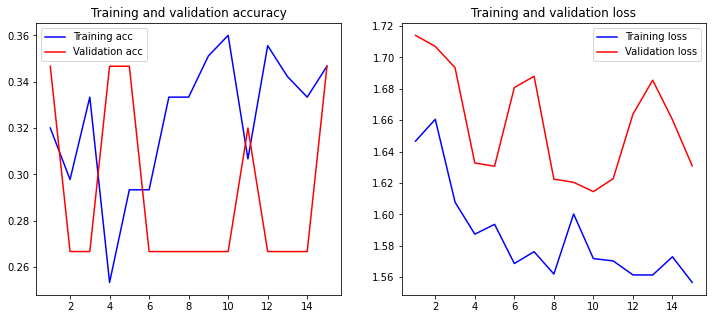

In [9]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)